# Pollution

In [63]:
#import statements
import numpy as np 
from numpy import mean, absolute
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import tree
from scipy.stats import t
from itertools import combinations

In [32]:
#read data from the file location, print data source information section and store data into a list
data = []
f = open('Pollution_files/pollution.txt', encoding='latin-1')
for i, line in enumerate(f):
    if i<=21:
        print(line, end="")
    else:
        if (i%2)==0:
            row = line.split()
        elif (i%2)==1:
            row+=line.split()
            data.append(row)


This is the pollution data so loved by writers of papers on ridge regression.
Source: McDonald, G.C. and Schwing, R.C. (1973) 'Instabilities of regression
estimates relating air pollution to mortality', Technometrics, vol.15, 463-
482.
Variables in order:
PREC   Average annual precipitation in inches
JANT   Average January temperature in degrees F
JULT   Same for July
OVR65  % of 1960 SMSA population aged 65 or older
POPN   Average household size
EDUC   Median school years completed by those over 22
HOUS   % of housing units which are sound & with all facilities
DENS   Population per sq. mile in urbanized areas, 1960
NONW   % non-white population in urbanized areas, 1960
WWDRK  % employed in white collar occupations
POOR   % of families with income < $3000
HC     Relative hydrocarbon pollution potential
NOX    Same for nitric oxides
SO@    Same for sulphur dioxide
HUMID  Annual average % relative humidity at 1pm
MORT   Total age-adjusted mortality rate per 100,000



In [42]:
#convert the data to a dataframe
cols = ['PREC', 'JANT', 'JULT', 'OVR65', 'POPN', 'EDUC', 'HOUS', 'DENS', 'NONW', 'WWDRK', 'POOR', 'HC', 'NOX', 'SO@', 'HUMID', 'MORT']
df = pd.DataFrame(data, columns=cols).astype(float)

In [43]:
df.sample(5)

,PREC,JANT,JULT,OVR65,POPN,EDUC,HOUS,DENS,NONW,WWDRK,POOR,HC,NOX,SO@,HUMID,MORT
44,32.0,25.0,72.0,10.9,3.21,11.1,82.5,4355.0,5.0,46.4,10.8,7.0,4.0,18.0,60.0,874.281
21,31.0,24.0,72.0,9.0,3.37,10.9,82.8,3226.0,5.1,45.2,12.3,5.0,3.0,10.0,61.0,871.338
51,38.0,24.0,72.0,9.8,3.34,11.4,78.0,4923.0,3.8,50.5,11.1,8.0,5.0,25.0,61.0,950.672
37,42.0,33.0,77.0,9.7,3.03,10.7,83.5,7462.0,11.3,48.7,12.4,41.0,26.0,108.0,58.0,994.648
25,39.0,29.0,75.0,8.7,3.23,11.4,78.6,4412.0,15.6,46.6,13.2,13.0,7.0,33.0,60.0,968.665


In [44]:
#verify that there are no missing values
df.isna().sum()

PREC     0
JANT     0
JULT     0
OVR65    0
POPN     0
EDUC     0
HOUS     0
DENS     0
NONW     0
WWDRK    0
POOR     0
HC       0
NOX      0
SO@      0
HUMID    0
MORT     0
dtype: int64

In [48]:
cols = list(df.columns)
target_col = 'MORT'
N = df[target_col].count()
X_cols = cols[:-1]

X=df[X_cols]
y=df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.6, random_state=0)

In [49]:
data = {'Training': [len(X_train), len(X_train)/N],
        'Validation': [len(X_test), len(X_test)/N]}

dfPartitionValidation = pd.DataFrame.from_dict(data, orient='index', columns=['# Records', '% Records'])
dfPartitionValidation

,# Records,% Records
Training,36,0.6
Validation,24,0.4


## Train the decision tree

In [50]:
def lowest_mse(X_train, X_test, y_train, y_test, max_depth=30,min_samples_leaf=30,max_leaf_nodes=30):
    """Prune model by testing values of max depth, min samples leaf and max leaf nodes. Return the model
    with the least complexity and lowest mean squared error"""
    mse = []
    maxDepthList = []
    minSamplesLeafList = []
    maxLeafNodes = []
    for i in range(1,max_depth):
        for j in range(2,min_samples_leaf):
            for k in range(2,max_leaf_nodes):
                dtree = DecisionTreeRegressor(random_state=0,max_depth=i, min_samples_leaf=j, max_leaf_nodes=k)
                dtree.fit(X_train, y_train)
                pred = dtree.predict(X_test)
                mse.append(mean_squared_error(y_test, pred))
                maxDepthList.append(i)
                minSamplesLeafList.append(j)
                maxLeafNodes.append(k)
    dfModels = pd.DataFrame({'mse': pd.Series(mse),
                    'max depth': pd.Series(maxDepthList),
                    'min samples leaf': pd.Series(minSamplesLeafList),
                    'max leaf nodes': pd.Series(maxLeafNodes)})
    #sort the dataframe by mse and complexity
    dfModels = dfModels.sort_values(by=['mse','max depth','min samples leaf','max leaf nodes']).reset_index()
    #return the pruned model
    prunedTree = DecisionTreeRegressor(random_state=0,max_depth=dfModels['max depth'][0], min_samples_leaf=dfModels['min samples leaf'][0], max_leaf_nodes=dfModels['max leaf nodes'][0])
    prunedTree.fit(X_train, y_train)
    return prunedTree

In [51]:
prunedTree = lowest_mse(X_train, X_test, y_train, y_test)

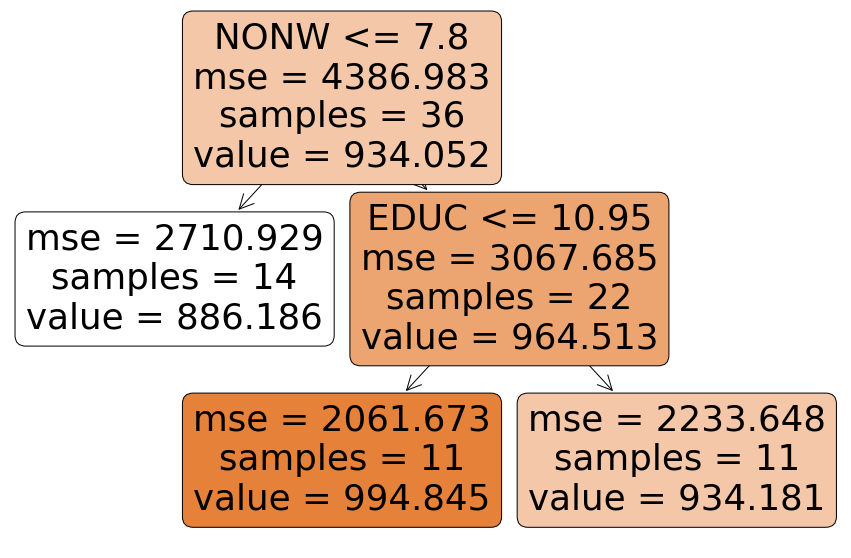

In [53]:
plt.figure(figsize=(15,10))
a = tree.plot_tree(prunedTree,
                    feature_names = list(X.columns),
                    filled = True,
                    rounded = True)

## Train the linear regression model

In [121]:
regrAll = LinearRegression()
regrAll.fit(X_train, y_train)
pred = regrAll.predict(X_test)

## Stepwise feature reduction model

In [95]:
def metrics(y_test, predictions):
    metricDict = {
                'SSE' : sum((y_test-predictions)**2),
                'MSE' : mean_squared_error(y_test, predictions),
                'RMSE' : mean_squared_error(y_test, predictions)**.5,
                'MAD' : mean(absolute(y_test-predictions)),
                'R2' : r2_score(y_test, predictions)
                }
    
    return metricDict

In [114]:
def StepwiseReduction(X_train, X_test, y_train, y_test, measure='R2'):
    m = 0
    feats = list(X_train.columns)
    i=len(feats)
    while i >= 1:
        for featList in combinations(X_cols,i):
            X = X_train[list(featList)]
            regr = LinearRegression()
            regr.fit(X, y_train)
            pred = regr.predict(X_test[list(featList)])
            metricVals = metrics(y_test, pred)
            if metricVals[measure] > m:
                m = metricVals[measure]
                bestFeats = list(featList)
                bestModel = regr
        i-=1
    return bestFeats, bestModel


In [115]:
stepwise, regr = StepwiseReduction(X_train, X_test, y_train, y_test, measure='R2')

## Compare models

In [127]:
swRegression = metrics(y_test, regr.predict(X_test[stepwise]))
decisionTree = metrics(y_test, prunedTree.predict(X_test))
regression = metrics(y_test, regrAll.predict(X_test))

metricSummary = pd.DataFrame.from_dict(decisionTree, orient='index', columns=['DecisionTree'])
metricSummary['FullRegression'] = metricSummary.index.map(regression)
metricSummary['Step-wiseRegression'] = metricSummary.index.map(swRegression)

In [120]:
metrics(y_test, regr.predict(X_test[stepwise]))

{'SSE': 9875.423196238213,
 'MSE': 411.47596650992546,
 'RMSE': 20.284870384351127,
 'MAD': 16.40201675191889,
 'R2': 0.852158240265273}

In [130]:
#set precision to display in dataframes
pd.set_option('precision',2)

metricSummary

,DecisionTree,FullRegression,Step-wiseRegression
SSE,37960.96,295241.62,9875.42
MSE,1581.71,12301.73,411.48
RMSE,39.77,110.91,20.28
MAD,32.57,58.76,16.40
R2,0.43,-3.42,0.85
